# Actor-critic

- Value methods: 
    - good for finite set of actions
    - immediate reward signal
- Policy methods: 
    - good for continuous action space
    - reward has to be traced back to the present
        - good final reward may have poor actions along the way

Actor critic combines both with value Critic and policy Actor.


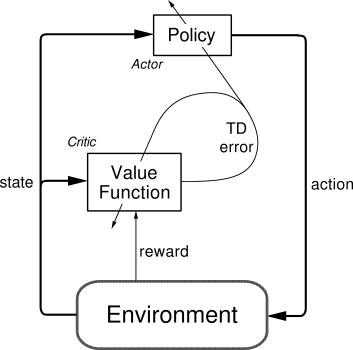 
Sutton

### Notation
| symbol     | meaning           |
|------------|-------------------|
| $\theta$   | policy parameters |
| $w$        | value parameters  |
| $s$        | states            |
| $\pi$      | policy agent      |
| $\alpha$   | learning rate     |
| $\delta_t$ | TD error          |
|            |                   |
|            |                   |




## algorithm
1. Initialize environment and actor/critic parameters
2. Sample action $a$ from $\pi_\theta$
3. For episodes
4. For $t = 1:T$
    1. Get reward $r_t$ and next state $s'$
    2. Get next action $a'$ from $\pi_\theta$
    3. Update policy $\theta \leftarrow \theta + \alpha_\theta Q_w (s, a) \nabla_\theta \ln \pi_\theta(a | s)$
    4. Compute action-value correction (TD error) at $t$:  
        $\delta_t = r_t + \gamma Q_w(s',a') - Q_w(s,a)$
    5. Update $w$ for action-value function:  
        $w \leftarrow w + \alpha_w \delta_t \nabla_w Q_w(s,a)$
    6. Update $a \leftarrow a'$ and $s \leftarrow s'$

- The policy and value function each have their own learning rate $\alpha$
- 


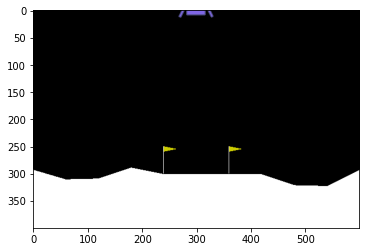

In [683]:

import gym
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque
import numpy as np
%matplotlib inline

env = gym.make('LunarLander-v2')
env.reset()
plt.imshow(env.render(mode="rgb_array"));


In [684]:
action_space = env.action_space.n
action_space

4

## Memory

In [685]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    def __len__(self):
        return len(self.buffer)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                 size=batch_size,
                                 replace=False)
        return [self.buffer[i] for i in index]
    def get_all(self):
        return [self.buffer[i] for i in range(len(self.buffer))]

In [686]:
mem = Memory(10)
[mem.add(i) for i in np.arange(10)]
mem.sample(5)
len(mem)

10

In [687]:
MEMORY_SIZE = 600
memory = Memory(max_size=MEMORY_SIZE)

state = env.reset() 

done = False
step_limit = 600
step = 0
while step < step_limit:
    
    random_action = env.action_space.sample()
    new_state, reward, done, info = env.step(random_action)
    
    
    memory.add((state, random_action, new_state, reward, done, info))
    
    if done:
        state = env.reset() 
        
    else:
        state = new_state
        
    step += 1

In [688]:
memory.get_all()[:1]


[(array([-0.00607834,  1.4075258 , -0.61568993, -0.1508842 ,  0.00705012,
          0.13946298,  0.        ,  0.        ], dtype=float32),
  2,
  array([-0.01233311,  1.4041197 , -0.63159484, -0.15142497,  0.01310823,
          0.12117425,  0.        ,  0.        ], dtype=float32),
  -2.1277800614919213,
  False,
  {})]

## Create actor and critic

In [689]:
# choose action from policy given state. pi_theta(a|s)
inputs = layers.Input(shape=(8,))
x = layers.Dense(50, activation="relu")(inputs)
x = layers.Dense(50, activation="relu")(x)
outputs = layers.Dense(4, activation="linear")(x)

actor = tf.keras.Model(inputs, outputs)

print(actor.output_shape)
actor(tf.random.uniform((3,8),-1,1))

(None, 4)


<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-0.3018984 , -0.05848737, -0.18876451,  0.3307313 ],
       [-0.05973458,  0.03833605, -0.11633739, -0.09609512],
       [-0.09662086, -0.01371588, -0.1884241 ,  0.03913995]],
      dtype=float32)>

In [690]:
# predict the Value V_w(s) of each action given the state
# this could also be Q_w(a|s)
inputs = layers.Input(shape=(8,))
x = layers.Dense(50, activation="relu")(inputs)
x = layers.Dense(50, activation="relu")(x)
outputs = layers.Dense(1, activation="linear")(x)

critic = tf.keras.Model(inputs, outputs)

print(critic.output_shape)
critic(tf.random.uniform((3,8),-1,1))

(None, 1)


<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.01346819],
       [-0.05886123],
       [ 0.12978306]], dtype=float32)>

In [691]:
def select_action(episode, actor, state, min_epsilon, max_epsilon, decay_rate):

    # random number for explore/exploit trade-off
    epsilon = np.random.rand()

    # current ee prob
    explore_prob = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)
    
    # get prob of actions
    action_probs = actor(tf.expand_dims(state, axis=0))
#     print(action_probs)
    
    # choose random action or max action_probs, epsilon greedy
    if epsilon < explore_prob:
        action = env.action_space.sample()
    else:
#         action = tf.squeeze(tf.argmax(action_probs, axis=-1)).numpy()
        action = tf.random.categorical(action_probs, 1)[0, 0].numpy()
        

    return tf.nn.softmax(action_probs), action

In [692]:
select_action(1, actor, tf.random.normal((8,)), 0.0, 0.0, 0.01)

(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.2198254 , 0.26489285, 0.27357182, 0.24170995]], dtype=float32)>,
 0)

# Train

In [693]:
total_episodes = 500       # Total number of training episodes
max_steps = 200               # Max steps per episode

alpha_theta = 0.01          # Learning rate
alpha_w = 0.01
gamma = 0.99                  # Discounting rate

# Exploration parameters
max_epsilon = 0             # Exploration probability at start
min_epsilon = 0            # Minimum exploration probability 
decay_rate = 0.003          # Exponential decay rate for exploration prob

actor_opt = tf.keras.optimizers.Adam(learning_rate=alpha_theta)
critic_opt = tf.keras.optimizers.Adam(learning_rate=alpha_w)

In [694]:
episode_reward_hist = []
actor_loss_hist = []
critic_loss_hist = []

for episode in range(total_episodes):

    step = 0
    state = env.reset()
    done = False
    episode_reward = 0   
    memory = Memory(max_steps)
    
    with tf.GradientTape(persistent=True) as tape:
        
        rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        log_actions = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        Vs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

        
        while not done and step < max_steps:

            step += 1
            action_probs_i, action = select_action(episode, actor, state, min_epsilon, max_epsilon, decay_rate)
            log_action_i = tf.math.log(tf.squeeze(action_probs_i)[action])
            

            value = critic(tf.expand_dims(state, axis=0))

            new_state, reward, done, info = env.step(action)

#             memory.add((state, action, log_action, value, new_state, reward, done, info))
            rewards = rewards.write(step, reward)
            log_actions = log_actions.write(step, log_action_i)
            values = values.write(step, value)

            state = new_state
            episode_reward += reward
    
        episode_reward_hist.append(episode_reward)
        
        rewards = rewards.stack()
        log_actions = log_actions.stack()
        values = values.stack()
        Vt = tf.constant(0.0) #critic(tf.expand_dims(new_state,0))
        

        replay = memory.get_all()

        # update value estimates
        for t in reversed(range(step+1)):
            Vt = rewards[t] + (gamma * Vt)
            Vs = Vs.write(t, Vt)

        Vs = Vs.stack()
        Vs = (Vs - tf.math.reduce_mean(Vs)) / (tf.math.reduce_std(Vs) + 1e-9)
        
        actor_loss = -tf.math.reduce_sum(log_actions * (Vs-values))
        critic_loss = tf.keras.losses.Huber()(tf.squeeze(values), Vs)
        loss = actor_loss + critic_loss
    
#     print([var.name for var in tape.watched_variables()])
    actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
    critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
    actor_opt.apply_gradients(zip(actor_grads, actor.trainable_variables))
    critic_opt.apply_gradients(zip(critic_grads, critic.trainable_variables))
    
    actor_loss_hist.append(actor_loss)
    critic_loss_hist.append(critic_loss)
    
    if episode % 10 == 0:
        print(f"Episode:{episode}, Loss: {(actor_loss.numpy(), critic_loss.numpy())}, Ep reward:{episode_reward}")

# actor_grads, critic_grads, [var.name for var in tape.watched_variables()]

Episode:0, Loss: (-1550.841, 0.4970286), Ep reward:-109.74810332443629
Episode:10, Loss: (-285.7864, 0.31177908), Ep reward:-106.12803642301864
Episode:20, Loss: (2127.9424, 0.35064587), Ep reward:-75.05904936887325


Exception ignored in: <function Viewer.__del__ at 0x000001F35B4C10D0>
Traceback (most recent call last):
  File "C:\Users\tim\anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\tim\anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\tim\anaconda3\lib\site-packages\pyglet\window\win32\__init__.py", line 319, in close
    super(Win32Window, self).close()
  File "C:\Users\tim\anaconda3\lib\site-packages\pyglet\window\__init__.py", line 838, in close
    app.windows.remove(self)
  File "C:\Users\tim\anaconda3\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x000001F3A4A14D10; to 'Win32Window' at 0x000001F35EBE8C10>


Episode:30, Loss: (726.71094, 0.58680224), Ep reward:-139.07930224278533
Episode:40, Loss: (8608.354, 0.117427245), Ep reward:-99.51977953439525
Episode:50, Loss: (-15066.703, 0.26359445), Ep reward:-99.86562136130121
Episode:60, Loss: (4619.463, 0.2789061), Ep reward:-50.37324504271295
Episode:70, Loss: (-13412.534, 0.16889726), Ep reward:4.455959740877333
Episode:80, Loss: (355.33887, 0.120718636), Ep reward:-52.80362557315196
Episode:90, Loss: (460.01782, 0.41018987), Ep reward:-226.59550511009806
Episode:100, Loss: (1142.3654, 0.25574055), Ep reward:-153.68319276172397
Episode:110, Loss: (1117.936, 0.1772107), Ep reward:-89.96694130755075
Episode:120, Loss: (919.05505, 0.10822184), Ep reward:-116.39440520511526
Episode:130, Loss: (799.5592, 0.34443194), Ep reward:-119.7270472548233
Episode:140, Loss: (-291.2859, 0.06482916), Ep reward:-87.9053075443241
Episode:150, Loss: (336.07465, 0.056278307), Ep reward:-84.42197099643613
Episode:160, Loss: (168.1084, 0.058078267), Ep reward:-84

In [695]:
# actor_loss_hist, critic_loss_hist, Vt

In [696]:
rewards

<tf.Tensor: shape=(126,), dtype=float32, numpy=
array([   0.        ,    0.3787529 ,    0.4815586 ,    1.0755763 ,
          1.21776   ,    1.5193752 ,   -0.80633223,   -1.2196506 ,
          1.0892184 ,    1.3726013 ,   -0.841202  ,   -1.3723541 ,
          0.9767885 ,   -1.290265  ,    1.0975114 ,    1.0451422 ,
         -1.1497834 ,    0.8705477 ,   -1.3893375 ,    0.6076085 ,
          0.75706184,   -1.0597293 ,    1.0777522 ,    1.1111505 ,
          1.0279318 ,   -1.9399599 ,   -2.0264533 ,    0.6955558 ,
         -0.21536267,   -1.8863406 ,   -0.558157  ,   -0.64467746,
         -1.855534  ,   -1.9313943 ,   -0.41312423,   -0.6314341 ,
         -1.911351  ,   -0.84260046,   -1.7320894 ,   -1.6927665 ,
         -0.47759804,   -1.7536867 ,   -0.6438114 ,   -0.63817865,
         -0.9341694 ,   -1.7443271 ,   -0.96037066,    1.347732  ,
         -1.755721  ,   -0.8772722 ,    2.4625669 ,   -1.582916  ,
         -0.92788357,    3.7844152 ,   -1.6259818 ,    0.5051568 ,
          1.31

In [697]:
tf.keras.losses.Huber()(-Vs, tf.squeeze(values))

<tf.Tensor: shape=(), dtype=float32, numpy=1.2181369>

In [698]:
tf.keras.losses.Huber()(tf.squeeze(values), -Vs)

<tf.Tensor: shape=(), dtype=float32, numpy=1.2181369>

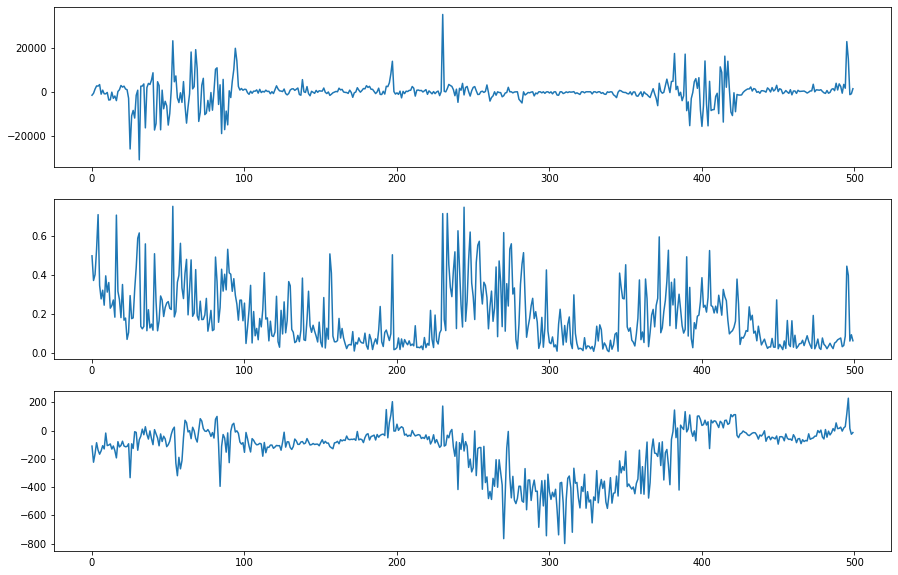

In [699]:
import pandas as pd
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(actor_loss_hist)
plt.subplot(3,1,2)
plt.plot(critic_loss_hist)
plt.subplot(3,1,3)
plt.plot(episode_reward_hist)
plt.show()

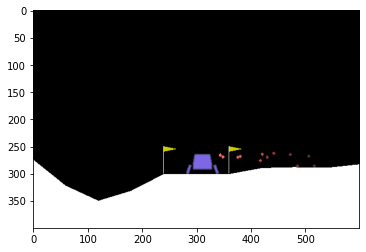

In [700]:
# Render an episode and save as a GIF file
from matplotlib import animation , rc
%matplotlib inline
fig = plt.figure()
images = []

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 

    state = tf.constant(env.reset(), dtype=tf.float32)
    for i in range(1, max_steps + 1):
        state = tf.expand_dims(state, 0)
        action_probs = model(state)
        action = np.argmax(np.squeeze(action_probs))

        state, _, done, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)

        # Render screen every 10 steps
        if i % 2 == 0:
            screen = plt.imshow(env.render(mode='rgb_array'))
            images.append([screen])

        if done:
            break

    return images


# Save GIF image
images = render_episode(env, actor, 200)
image_file = 'lunarLander.gif'


an = animation.ArtistAnimation(fig, images, interval=100, repeat_delay=1000, blit=True)
rc('animation', html='jshtml')
an

In [708]:
f = r"animation.gif" 
writergif = animation.PillowWriter(fps=30) 
an.save(f, writer=writergif)

In [701]:
#         rewards = np.array([r[5] for r in replay])
#         log_actions = np.array([r[2] for r in replay])
#         values = np.array([r[3] for r in replay])
#         Vs = np.zeros(len(memory))
        
#         rewards = tf.Variable([r[5] for r in replay], dtype=tf.float32)
#         log_actions = np.array([r[2] for r in replay])
#         values = np.array([r[3] for r in replay])
#         Vs = np.zeros(len(memory))
